# Imports

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from skimage import io
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle

import tensorflow
from tensorflow import keras
from tensorflow import cast
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import vgg16
from keras.utils.vis_utils import plot_model

#Utility library
from math import ceil
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
import gc

# Get dataset from link

In [ ]:
!wget https://filebox.ece.vt.edu/~vrama91/CIDEr_miscellanous/cider_datasets.tar
!tar -xzvf cider_datasets.tar

--2021-05-14 04:17:05--  https://filebox.ece.vt.edu/~vrama91/CIDEr_miscellanous/cider_datasets.tar
Resolving filebox.ece.vt.edu (filebox.ece.vt.edu)... 128.173.88.43
Connecting to filebox.ece.vt.edu (filebox.ece.vt.edu)|128.173.88.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1680626 (1.6M) [application/x-tar]
Saving to: ‘cider_datasets.tar’

cider_datasets.tar  100%[===================>]   1.60M  --.-KB/s    in 0.09s   

2021-05-14 04:17:06 (17.2 MB/s) - ‘cider_datasets.tar’ saved [1680626/1680626]

Datasets/
Datasets/abstract50S.mat
Datasets/pascal50S.mat


In [ ]:
pascal50s = loadmat('Datasets/pascal50S.mat')
pascal50s.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_sent_final'])

# Generate output targets

In [ ]:
class_labels = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'table', 'plant', 'sofa', 'monitor']

synonyms = {'person': ['people', 'persons', 'man', 'men', 'woman', 'women', 'child', 'children', 'baby', 'babies', 'kid', 'kids', 'lady', 'ladies', 'human', 'humans'],
            'bird': ['birds', 'duck', 'ducks'],
            'cat': ['cats', 'kitten', 'kitty', 'kittens'],
            'cow': ['cows', 'buffalo', 'buffalos', 'buffaloes', 'bull', 'bulls'],
            'dog': ['dogs', 'pup', 'puppy', 'puppies', 'pupper'],
            'horse': ['horses'],
            'aeroplane': ['aeroplanes', 'airplane', 'airplanes',  'plane', 'planes', 'jet', 'jets', 'aircraft', 'aircrafts', 'airship','airships', 'boeing'],
            'bicycle': ['bicycles', 'bike', 'bikes', 'cycles', 'cycle'],
            'boat': ['boats', 'canoe', 'kayak', 'raft', 'canoes', 'kayaks', 'rafts'],
            'bus': ['buses', 'truck', 'trucks', 'traffic'],
            'car': ['cars', 'parking', 'traffic'],
            'motorbike': ['motorcycle', 'motorcycles', 'motorbikes', 'scooter', 'motor', 'motor-bike'],
            'train': ['trains', 'locomotive', 'rail', 'railway', 'rails'],
            'bottle': ['bottles', 'tube', 'container', 'tubes', 'containers'],
            'chair': ['chairs', 'furniture', 'furnitures'],
            'table': ['tables', 'counter', 'furniture', 'furnitures', 'desk', 'tabletop', 'counters', 'desks', 'tabletops'],
            'plant': ['pot', 'pots', 'tree', 'trees', 'flower', 'flowers', 'bush', 'bushes', 'herb', 'herbs', 'garden', 'gardens'],
            'sofa': ['sofas', 'couch', 'recliner', 'couches', 'recliners'],
            'monitor': ['monitors', 'screens', 'televisions', 'tv', 'television', 'lcd', 'screen', 'plasma', 'computer', 'computers']
           }

labels_dict = {}
for i, label in enumerate(class_labels):
  labels_dict[label] = [i]

for i in synonyms.keys():
  for j in synonyms[i]:
    if j in labels_dict:
      labels_dict[j].append(labels_dict[i][0])
    else:
      labels_dict[j] = [labels_dict[i][0]]

num_classes = len(class_labels)
num_images = 1000
targets = np.zeros((num_images, num_classes)) #1 label for unknown class type

print(labels_dict)

{'person': [0], 'bird': [1], 'cat': [2], 'cow': [3], 'dog': [4], 'horse': [5], 'sheep': [6], 'aeroplane': [7], 'bicycle': [8], 'boat': [9], 'bus': [10], 'car': [11], 'motorbike': [12], 'train': [13], 'bottle': [14], 'chair': [15], 'table': [16], 'plant': [17], 'sofa': [18], 'monitor': [19], 'people': [0], 'persons': [0], 'man': [0], 'men': [0], 'woman': [0], 'women': [0], 'child': [0], 'children': [0], 'baby': [0], 'babies': [0], 'kid': [0], 'kids': [0], 'lady': [0], 'ladies': [0], 'human': [0], 'humans': [0], 'birds': [1], 'duck': [1], 'ducks': [1], 'cats': [2], 'kitten': [2], 'kitty': [2], 'kittens': [2], 'cows': [3], 'buffalo': [3], 'buffalos': [3], 'buffaloes': [3], 'bull': [3], 'bulls': [3], 'dogs': [4], 'pup': [4], 'puppy': [4], 'puppies': [4], 'pupper': [4], 'horses': [5], 'aeroplanes': [7], 'airplane': [7], 'airplanes': [7], 'plane': [7], 'planes': [7], 'jet': [7], 'jets': [7], 'aircraft': [7], 'aircrafts': [7], 'airship': [7], 'airships': [7], 'boeing': [7], 'bicycles': [8], '

In [ ]:
import re
def getWords(text):
    return re.compile('[A-Za-z]+').findall(text)

data = pascal50s['train_sent_final']
data = data.flatten()

for i in range(len(data)):
  data[i][1] = data[i][1].flatten()
  for sentence in (data[i][1]):
    sentence = sentence[0]
    for word in getWords(sentence):
      if (word in labels_dict):
        for j in labels_dict[word]:
          targets[i][j] = 1

In [ ]:
count = 0
for i in targets:
  if(sum(i) == 0):
    count += 1
print(count)

1


In [ ]:
print(targets.shape)

np.save("targets.npy", targets)

(1000, 20)


<BarContainer object of 20 artists>

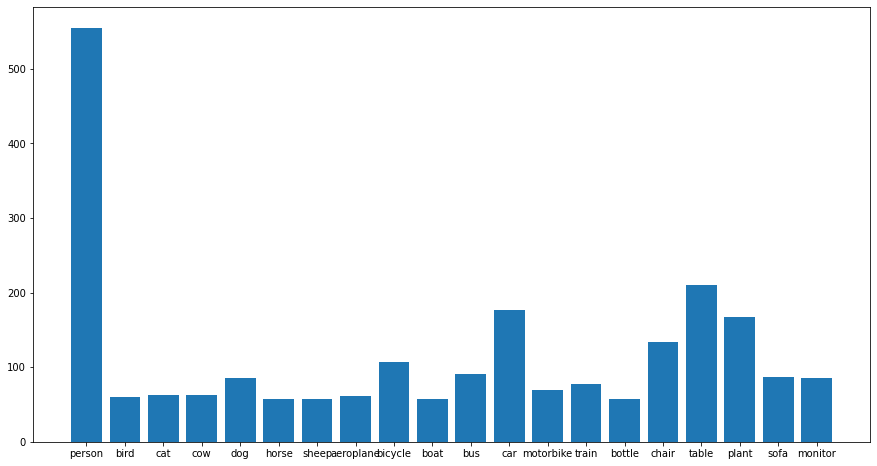

In [ ]:
targets.sum(axis=0)
plt.figure(figsize=(15,8))
plt.bar(class_labels, targets.sum(axis=0))

<BarContainer object of 7 artists>

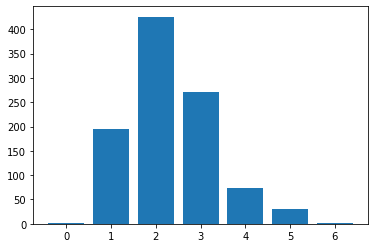

In [ ]:
cnt = np.unique( targets.sum(axis=1) ,return_counts=True)
plt.bar( cnt[0], cnt[1])

In [ ]:
# !cp targets.npy drive/MyDrive/IITPKD_DL_Project\ dataset/

# Convert images to numpy arrays and store in a list

In [ ]:
image_data = []
for element in data:
  image_url = element[0][0]
  image_numpy = io.imread(image_url)
  image_data.append(image_numpy)

In [ ]:
len(image_data)

1000

In [ ]:
image_sizes = []
for i in image_data:
  image_sizes.append([i.shape[0], i.shape[1], i.shape[2]])

In [ ]:
print(np.max(image_sizes, axis=0))
np.median(image_sizes, axis=0)

[500 500   3]


array([375., 500.,   3.])

In [ ]:
resize_to = (250, 250)
for i in range(len(image_data)):
  image_data[i] = cv2.resize(image_data[i], dsize=resize_to)

image_data = np.array(image_data)
image_data.shape

(1000, 250, 250, 3)

# Dataset from drive

In [ ]:
!gdown --id 1-4zf03wZl4LmbC5aDMkzJSW-jEqWOTCF
!gdown --id 1--zB7YfvyGRIgBrD_8HcNmeHHGJg8Ji9

Downloading...
From: https://drive.google.com/uc?id=1-4zf03wZl4LmbC5aDMkzJSW-jEqWOTCF
To: /content/image_data.npy
188MB [00:01, 166MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--zB7YfvyGRIgBrD_8HcNmeHHGJg8Ji9
To: /content/targets.npy
100% 160k/160k [00:00<00:00, 59.9MB/s]


In [ ]:
targets = np.load("targets.npy")
images = np.load("image_data.npy")
print(targets.shape)
print(images.shape)

(1000, 20)
(1000, 250, 250, 3)


In [ ]:
# def normalize(x):
#     norm = np.sum(x)
#     if norm == 0: 
#        return x
#     return x / norm

# inv_class_frequency = 1.0/((np.sum(targets, axis=0))/targets.shape[0])
# weights =normalize(np.sqrt(inv_class_frequency))

# class_weights = {}
# for i, wt in enumerate(weights):
#   class_weights[i] = wt*10

# print(class_weights)

{0: 0.19791771386965967, 1: 0.601943227004325, 2: 0.5874364391443962, 3: 0.5874364391443962, 4: 0.5057334674938245, 5: 0.6122336002250541, 6: 0.6175807200907172, 7: 0.5969888775110048, 8: 0.4507536670268554, 9: 0.6122336002250541, 10: 0.4887766620948697, 11: 0.35145912500103527, 12: 0.5613149534692238, 13: 0.5279391344116948, 14: 0.6122336002250541, 15: 0.4027900726535226, 16: 0.3217521888198966, 17: 0.36080531111395914, 18: 0.499886641312829, 19: 0.5027845591626282}


**DataSet Split**

Train : Test

80 : 20 split after shuffle

In [ ]:
x_train, y_train = shuffle(images, targets, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 250, 250, 3)
(200, 250, 250, 3)
(800, 20)
(200, 20)


# Model and Training

In [ ]:
EPOCHS = 30
savefilepath = 'savedVggModel/cp.ckpt'
class_labels = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'table', 'plant', 'sofa', 'monitor']
num_classes = len(class_labels)

In [ ]:
def getCNNModel(nConvs=2, nRep=1, type=0, filter_count=64, denseUnits=[128], dropout=0.5, num_classes=20): #type 0 means flatten layer to be used, any other value means global average pooling layer to be used
  model = Sequential()
  first_layer = 1 # utility variable used to determine whether the convlution layer being added is the very first layer in the model
  for i in range(nRep): # number of repetitions of layers, that is: ((Conv2d + BatchNorm)*nConvs + Pooling)*nRep
    for j in range(nConvs):
      name_suffix = str(i*nConvs + j)
      if(first_layer == 1): #if it's the very first layer of the model, we need to specify the input shape
        first_layer = 0
        model.add(Conv2D(input_shape=(250,250,3),filters=filter_count, kernel_size=(3,3),padding="same", activation="relu", name='Conv_'+name_suffix))
      else:
        model.add(Conv2D(filters=filter_count,kernel_size=(3,3),padding="same", activation="relu", name='Conv_'+name_suffix))

      model.add(BatchNormalization(name='BN_'+name_suffix))

    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='MP_'+str(i)))
  
  for i in range(nConvs):
    model.add(Conv2D(filters=filter_count,kernel_size=(3,3),padding="same", activation="relu", name='Conv_'+str(nConvs*nRep + i)))
    model.add(BatchNormalization(name='BN_'+str(nConvs*nRep + i)))
    
  if (type == 0):
    model.add(Flatten())
  else:
    model.add(GlobalAveragePooling2D())
  
  model.add(Dropout(rate = dropout))
  
  for i in denseUnits:
    model.add(Dense(units=i,activation="relu"))
  
  model.add(Dense(units=num_classes,activation="sigmoid")) #binary classification so sigmoid is enough
  return model

In [ ]:
def vgg16Model(pretrained, dropout, num_classes, denseUnits=[256]):

  if pretrained:
    baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(250, 250, 3)))
  else:
    baseModel = VGG16(include_top=False, input_tensor=Input(shape=(250, 250, 3)))


  headModel = baseModel.output
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dropout(dropout)(headModel)
  for i in denseUnits:
    headModel = Dense(i, activation="relu")(headModel)
  headModel = Dense(num_classes, activation="sigmoid")(headModel)
  if pretrained:
    for layer in baseModel.layers:
      layer.trainable = False
  model = Model(inputs=baseModel.input, outputs=headModel)
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  return model

## Cross Validation

In [ ]:
# def train_cv(x, y, lrate, fnn, batch_size, dropout):
#   kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#   cvscores = []
#   history = []
#   split_count = 1
#   proc_x = vgg16.preprocess_input(x)
#   for train, val in kfold.split(proc_x):
#     print("CV split:", split_count)
#     split_count += 1
#     model = vgg16Model(True, dropout, num_classes, fnn)
#     optimizer = Adam(learning_rate=lrate)
#     model.compile(optimizer=optimizer,
#                   loss="binary_crossentropy",
#                   metrics=[AUC(multi_label=True), keras.metrics.Precision(), keras.metrics.Recall()])
    
#     #model save at checkpoint callback
#     # checkpoint = ModelCheckpoint(savefilepath, monitor= 'val_loss', mode= 'min', save_weights_only = True, verbose= 1)
#     #early stopping callback
#     # es_cb = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#     hs = model.fit(x=proc_x[train], y=y[train], epochs=EPOCHS, validation_data=(proc_x[val], y[val]), batch_size=batch_size, verbose=1)
#     history.append(hs.history)
    
  
#   return history
    

In [ ]:
# lrates = [3e-3]
# fnn_units = [[128]]
# batch_sizes = [64]
# dropout = 0.75

# cvhistory = []
# for lrate in lrates:
#   for fnn in fnn_units:
#     for batch_size in batch_sizes:
#       hist = train_cv(x_train, y_train, lrate, fnn, batch_size, dropout)
#       cvhistory.append(hist)

## Train

* AUC ROC

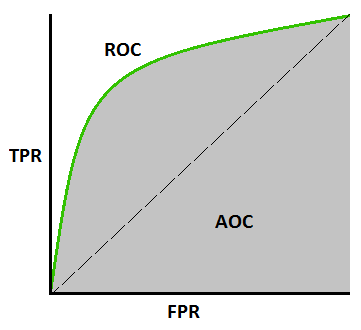

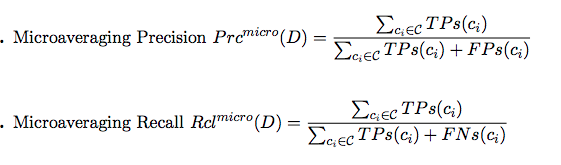

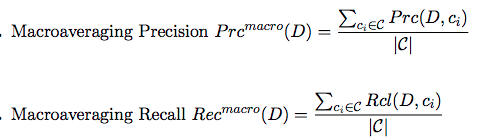

In [ ]:
def train(x, y, lrate, fnn, batch_size, dropout, nEpochs, model = 'pretrained'):
  if model == 'pretrained':
    proc_x = vgg16.preprocess_input(x)
    model = vgg16Model(True, dropout, num_classes, fnn)
  else:
    model = getCNNModel()
    proc_x = x
  print(model.summary())
  optimizer = Adam(learning_rate=lrate)
  model.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=[AUC(multi_label=True), keras.metrics.Precision(), keras.metrics.Recall()])
  
  #model save at checkpoint callback
  checkpoint = ModelCheckpoint(savefilepath, monitor= 'auc', mode= 'max', save_best_only=True, save_weights_only=True, verbose= 1)
  #early stopping callback
  # es_cb = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  history = model.fit(x=proc_x, y=y, epochs=nEpochs, batch_size=batch_size, verbose=1, callbacks=[checkpoint])
  keras.backend.clear_session()
  gc.collect()
  del model
  return history

In [ ]:
nEpochs = 20

In [ ]:
lrate = 1e-3
fnn = [128]
batch_size = 32
dropout = 0.75

In [ ]:
# VGG16 CNN Model
history = train(x_train, y_train, lrate, fnn, batch_size, dropout, nEpochs=nEpochs)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0   

In [ ]:
def plotAcc(history):
#   plt.plot(history["val_acc"])
  plt.plot(history["auc"])
  plt.plot(history["precision"])
  plt.plot(history["recall"])
  plt.title("Model Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("metric")
  plt.legend(["AUC","Precision", "Recall"], loc="best")
  plt.show()


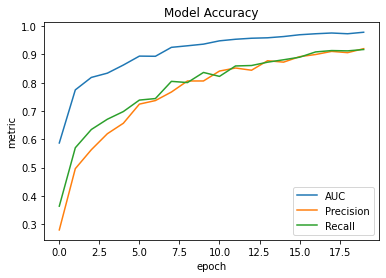

In [ ]:
plotAcc( history.history)

In [ ]:
# # Custom CNN Model
# history = train(x_train, y_train, lrate, fnn, batch_size, dropout, nEpochs=nEpochs, model='custom')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_0 (Conv2D)              (None, 250, 250, 64)      1792      
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 250, 250, 64)      256       
_________________________________________________________________
Conv_1 (Conv2D)              (None, 250, 250, 64)      36928     
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 250, 250, 64)      256       
_________________________________________________________________
MP_0 (MaxPooling2D)          (None, 125, 125, 64)      0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 125, 125, 64)      2

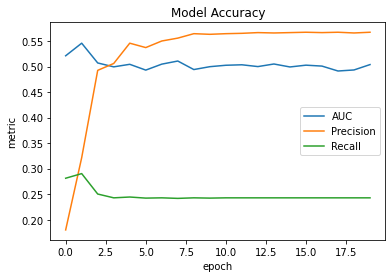

In [ ]:
# plotAcc( history.history)

## Results

In [ ]:
def getLabels(preds, confidence):
  result = []
  for pred in preds:
    res = []
    for i, prob in enumerate(pred):
      if prob > confidence:
          res.append(class_labels[i])
    result.append(res)
  return result

In [ ]:
model = vgg16Model(True, 0, num_classes, [128])
model.load_weights(savefilepath)

In [ ]:
model.save("task1_model")

INFO:tensorflow:Assets written to: task1_model/assets


In [ ]:
#model = keras.models.load_model("drive/MyDrive/IITPKD_DL_Project/task1_model")

In [ ]:
img = x_test
proc_img = vgg16.preprocess_input(img)

In [ ]:
labs = model.predict(proc_img)

In [ ]:
def show_result(idx, conf=0.5):
    plt.imshow(img[idx])
    print(getLabels(labs, conf)[idx])
    

['plant']


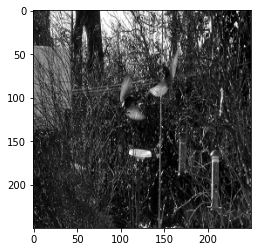

In [ ]:
show_result(0)

['cat']


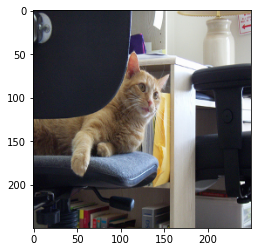

In [ ]:
show_result(8)

['aeroplane']


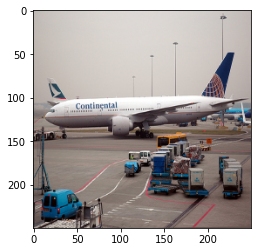

In [ ]:
show_result(15)

['person', 'table']


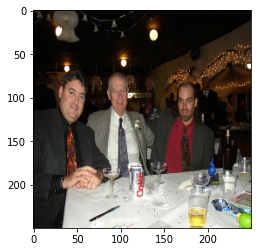

In [ ]:
show_result(25)

['horse']


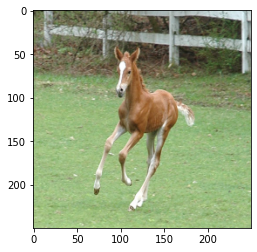

In [ ]:
show_result(40)

['person']


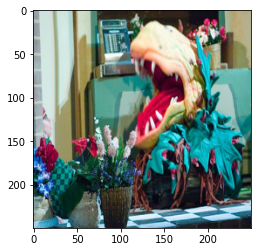

In [ ]:
show_result(10)

['person']


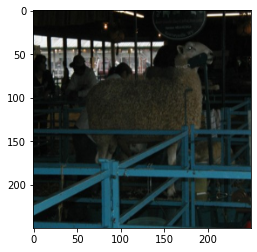

In [ ]:
show_result(15)

[]


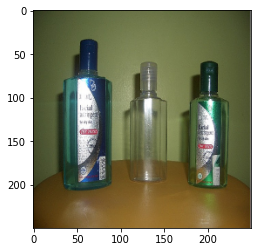

In [ ]:
show_result(40)

['person', 'table']


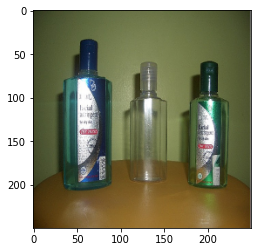

In [ ]:
show_result(40, 0.02)

In [ ]:
optimizer = Adam(learning_rate=lrate)
model.compile(metrics=[AUC(multi_label=True), keras.metrics.Precision(), keras.metrics.Recall()])
eval = model.evaluate(proc_img, y_test)

7/7 [==============================] - 3s 301ms/step - loss: 0.0000e+00 - auc: 0.7033 - precision: 0.6853 - recall: 0.4515


In [ ]:
keras.backend.clear_session()
gc.collect()

18629